In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf
import scipy.stats as sps
import edward as ed
import edward.models as edm
from tensorflow.contrib.linalg import LinearOperatorTriL
import itertools
ds = tf.contrib.distributions

In [2]:
# http://edwardlib.org/tutorials/unsupervised
def build_toy_dataset(N):
  pi = np.array([0.3, 0.2,0.5])
  mus = [[1, 3], [-2, -5],[5,-3]]
  #stds = [[[0.1, 0.1], [0.1, 0.1]], [[0.1, 0.1], [0.1, 0.1]] ]\\
  stds = np.array([[[1,1.5], [1.5, 2.5]], [[1, 0], [0, 1]],[[2, -1.2], [-1.2, 2]] ])
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], stds[k,:,:])

  return x

N = 500  # number of data points
D = 2  # dimensionality of data

x_train = build_toy_dataset(N)

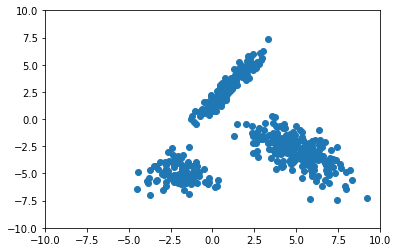

In [3]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-10, 10, -10, 10])
plt.show()

$$\text{Pr}(\textbf{x}_i|\boldsymbol{\pi},\boldsymbol{\mu},\boldsymbol{\Sigma})=\sum_{k=1}^K \pi_k \text{N}(\textbf{x}_i|\mu_k,\Sigma_k)$$

$$\begin{aligned}
\pi_k\sim&\text{Dir}(\pi_k|\boldsymbol{\alpha})\\
\mu_k\sim&\text{N}(\mu_k|\boldsymbol{\mu}_0,\Sigma_0)\\
\Sigma_k\sim&\text{Wischart}(\nu_0,\Psi_0)
\end{aligned}$$

In [4]:
K = 3 # number of components
# priors
nu0 = tf.Variable(D, dtype=tf.float32, trainable=False)
psi0 = tf.Variable(np.eye(D),
                      dtype=tf.float32, trainable=False)
mu0 = tf.Variable(np.zeros(D), dtype=tf.float32, trainable=False)
sigma0 = tf.Variable(np.eye(D),
                      dtype=tf.float32, trainable=False)
#pi = edm.Dirichlet(tf.ones([N,K]))
alphas=tf.Variable(tf.ones([K]))
pi = edm.Dirichlet(alphas)
#pi2=edm.Dirichlet(np.ones(K, dtype=np.float32))
sigma = edm.WishartCholesky(df=nu0, scale=psi0,cholesky_input_output_matrices=True,sample_shape=K)
mu = edm.MultivariateNormalTriL(mu0,sigma0,sample_shape=K)
#mu = edm.Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
#cat = edm.Categorical(probs=pi)
#cat2 = edm.Categorical(logits=(tf.zeros([N, K])))
# components = [
#     edm.MultivariateNormalDiag(mu[k], sigma[k], sample_shape=N)
#     for k in range(K)]
# x = edm.Mixture(cat=cat, components=components)

In [5]:
#x = edm.Mixture(cat=cat, components=components,sample_shape=N)
x=edm.ParamMixture(pi,{'loc':mu,'scale_tril':sigma},edm.MultivariateNormalTriL,sample_shape=N)
z=x.cat

In [6]:
qpsi0 = tf.Variable(tf.random_normal([K,D, D], dtype=tf.float32))
Ltril = LinearOperatorTriL(ds.matrix_diag_transform(qpsi0, transform=tf.nn.softplus)).to_dense()
qsigma=edm.WishartCholesky(df=tf.ones([K])*100,scale=Ltril)


In [7]:
qmu = edm.Normal(
    loc=tf.Variable(tf.random_normal([K, D])),
    scale=tf.nn.softplus(tf.Variable(tf.zeros([K, D]))))
#qmu0 = tf.Variable(tf.random_normal([K,D], dtype=tf.float32))
# qR = tf.Variable(tf.random_normal([K,D, D], dtype=tf.float32))
# #qmu = edm.MultivariateNormalTriL(qmu0, qR,sample_shape=K)
# qmu=tf.stack([edm.MultivariateNormalTriL(qmu0[k], qR[k]) for k in range(K)],axis=0)

In [8]:
#qcat = edm.Categorical(logits=(tf.Variable(tf.random_normal([N,K]))))
qpi_alpha = tf.nn.softplus(tf.Variable(tf.random_normal([K])))
#pi = edm.Dirichlet(tf.ones([N,K]))
qpi = edm.Dirichlet(qpi_alpha)
#qcat = edm.Categorical(probs=qpi)
#qz = edm.Categorical(probs=qpi,sample_shape=N)
#qcat_varlist=(tf.Variable(tf.random_normal([N,K])))
#qcat = edm.Categorical(logits=qcat_varlist)

In [9]:
inference = ed.KLqp({mu: qmu, sigma: qsigma}, data={x:x_train}) # pi:qpi



In [10]:
inference.initialize(n_iter=2000, n_print=50, n_samples=30)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

{'t': 1, 'loss': 42882.938}
{'t': 51, 'loss': 7.0333926e+08}
{'t': 101, 'loss': 8019.4463}
{'t': 151, 'loss': 29987.531}
{'t': 201, 'loss': 78930.367}
{'t': 251, 'loss': 16198.523}
{'t': 301, 'loss': 3065343.5}
{'t': 351, 'loss': 24436.631}
{'t': 401, 'loss': 53407.898}
{'t': 451, 'loss': 53635.703}
{'t': 501, 'loss': 56917.391}
{'t': 551, 'loss': 38664.164}
{'t': 601, 'loss': 2937691.0}
{'t': 651, 'loss': 37672.387}
{'t': 701, 'loss': 1544948.5}
{'t': 751, 'loss': 493377.66}
{'t': 801, 'loss': 22179.717}
{'t': 851, 'loss': 2711682.5}
{'t': 901, 'loss': 1748655.3}
{'t': 951, 'loss': 2777756.5}
{'t': 1001, 'loss': 44278.77}
{'t': 1051, 'loss': 26282.641}
{'t': 1101, 'loss': 5764.6587}
{'t': 1151, 'loss': 39787.375}
{'t': 1201, 'loss': 24722.273}
{'t': 1251, 'loss': 218973.03}
{'t': 1301, 'loss': 266089.09}
{'t': 1351, 'loss': 65547.539}
{'t': 1401, 'loss': 2328351.0}
{'t': 1451, 'loss': 283959.09}
{'t': 1501, 'loss': 994580.69}
{'t': 1551, 'loss': 17921.471}
{'t': 1601, 'loss': 33205.5}

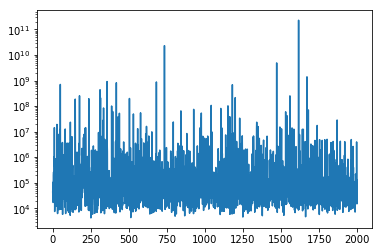

In [11]:
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%50 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
plt.semilogy(learning_curve)

In [12]:
qmu.loc.eval()

array([[-0.05017852,  0.00652133],
       [-0.06993062, -0.08255748],
       [ 0.02360224, -0.07114367]], dtype=float32)

In [13]:
LL0=Ltril[0].eval()
LL1=Ltril[1].eval()
LL2=Ltril[2].eval()
psi_eval0=np.matmul(LL0,np.transpose(LL0))

psi_eval1=np.matmul(LL1,np.transpose(LL1))

psi_eval2=np.matmul(LL2,np.transpose(LL2))

In [14]:
sigma_draws0=sps.wishart.rvs(100,psi_eval0,N)
sigma_draws1=sps.wishart.rvs(100,psi_eval1,N)
sigma_draws2=sps.wishart.rvs(100,psi_eval2,N)

In [15]:
mu_draws0=sps.multivariate_normal.rvs(qmu.loc[0].eval(),np.diag(qmu.scale[0].eval()),N)
mu_draws1=sps.multivariate_normal.rvs(qmu.loc[1].eval(),np.diag(qmu.scale[1].eval()),N)
mu_draws2=sps.multivariate_normal.rvs(qmu.loc[2].eval(),np.diag(qmu.scale[2].eval()),N)

In [16]:
x_draws0=np.zeros([N,2])
x_draws1=np.zeros([N,2])
x_draws2=np.zeros([N,2])

In [17]:
for i in range(N):
    x_draws0[i,:]=sps.multivariate_normal.rvs(mu_draws0[i,:],sigma_draws0[i,:,:])
    x_draws1[i,:]=sps.multivariate_normal.rvs(mu_draws1[i,:],sigma_draws1[i,:,:])
    x_draws2[i,:]=sps.multivariate_normal.rvs(mu_draws2[i,:],sigma_draws2[i,:,:])
    

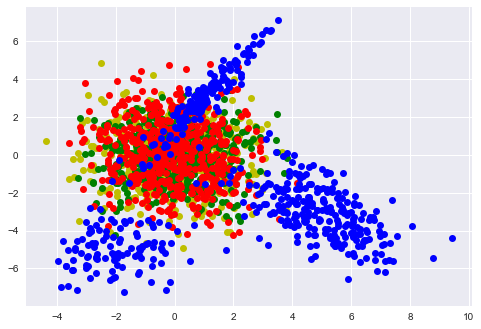

In [18]:
plt.plot(x_draws2[:,0],x_draws2[:,1],'yo',x_draws1[:,0],x_draws1[:,1],'go',x_draws0[:,0],x_draws0[:,1],'ro',x_train[:,0],x_train[:,1],'bo')